In [1]:
import pandas as pd
import numpy as np
import scipy as sc
import gensim as gs
import matplotlib.pyplot as plt
%matplotlib inline

# nltk
import nltk
from nltk.tokenize import word_tokenize as wt
from nltk.tokenize import sent_tokenize as st

import Levenshtein

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# keras
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras.layers import Dense,LSTM,Input,Activation,Add,TimeDistributed,Permute,Flatten,RepeatVector
from keras.layers import merge,Lambda,Multiply,Reshape, Bidirectional
from keras.layers.wrappers import TimeDistributed
from keras.layers.embeddings import Embedding
from keras.models import Sequential,Model
from keras.optimizers import RMSprop
from keras import backend as K
from keras.utils import np_utils

# useful libraries
import logging
import re
from collections import Counter
from itertools import chain
import random
import sys

# utils
import utils, utils_updated

Using TensorFlow backend.


In [2]:
# globals
seed = 42
embedding_size=100

In [3]:
papers = pd.read_csv('../data/papers.csv')
print(papers.shape)
papers.head()

(7241, 7)


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


#### Preprocessing

In [4]:
papers = utils_updated.preprocessing(papers)
papers = papers.dropna(subset=['abstract'])
print(papers.shape)
papers['a_len'] = [len(abst.split()) for abst in papers['abstract']]
papers = papers[papers['a_len'] < 250]
print(papers.shape)
titles, abstracts = list(papers['title']),list(papers['abstract'])

(7174, 7)
(4659, 8)


In [5]:
i = 10
print('Abstract : ',abstracts[i])
print('Title : ', titles[i])
print(type(titles[0]),type(abstracts[0]))

Abstract :  the paper presents a rapid speaker-normalization technique based on neural network spectral mapping. the neural network is used as a front-end of a continuous speech recognition system (speakerdependent, hmm-based) to normalize the input acoustic data from a new speaker. the spectral difference between speakers can be reduced using a limited amount of new acoustic data (40 phonetically rich sentences). recognition error of phone units from the acoustic-phonetic continuous speech corpus apasci is decreased with an adaptability ratio of 25%. we used local basis networks of elliptical gaussian kernels, with recursive allocation of units and on-line optimization of parameters (gran model). for this application, the model included a linear term. the results compare favorably with multivariate linear mapping based on constrained orthonormal transformations.  1
Title :  connectionist speaker normalization with generalized resource allocating networks
<class 'str'> <class 'str'>


In [6]:
def get_vocab(lst):
    vocabcount = Counter(w for txt in lst for w in txt.split())
    vocab = map(lambda x: x[0], sorted(vocabcount.items(), key=lambda x: -x[1]))
    return list(vocab), vocabcount

In [7]:
vocab, vocabcount = get_vocab(titles+abstracts)
print("Most common words : ", vocab[:50])

Most common words :  ['the', 'of', 'a', 'and', 'to', 'in', 'we', 'for', 'is', 'that', 'on', 'with', 'this', 'learning', 'as', 'are', 'an', 'by', 'our', 'can', 'which', 'from', 'be', 'model', 'algorithm', 'data', 'show', 'using', 'it', 'neural', 'problem', 'models', 'method', 'such', 'these', 'based', 'approach', 'results', 'algorithms', 'new', 'network', 'propose', 'or', 'has', 'networks', 'have', 'methods', 'number', 'between', 'also']


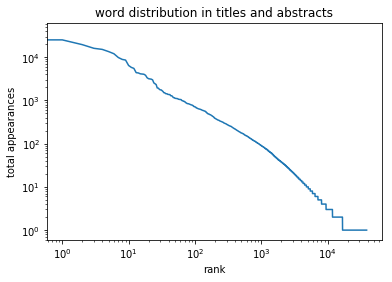

In [8]:
plt.plot([vocabcount[w] for w in vocab]);
plt.gca().set_xscale("log", nonposx='clip')
plt.gca().set_yscale("log", nonposy='clip')
plt.title('word distribution in titles and abstracts')
plt.xlabel('rank')
plt.ylabel('total appearances');

In [9]:
empty = 0 # RNN mask of no data
eos = 1  # end of sentence
start_idx = eos+1 # first real word

def get_idx(vocab, vocabcount):
    word2idx = dict((word, idx+start_idx) for idx,word in enumerate(vocab))
    word2idx['<empty>'] = empty
    word2idx['<eos>'] = eos
    
    idx2word = dict((idx,word) for word,idx in word2idx.items())

    return word2idx, idx2word

word2idx, idx2word = get_idx(vocab, vocabcount)
print('Vocabulary length :', len(word2idx))
vocab_size = len(word2idx)

Vocabulary length : 38659


In [10]:
embedding_dim = 100
fname = 'glove.6B.%dd.txt'%embedding_dim
import os
datadir_base = '../'
datadir = os.path.join(datadir_base, 'data')
glove_name = os.path.join(datadir, fname)
print(glove_name)

../data/glove.6B.100d.txt


In [11]:
glove_index_dict = {}
glove_embedding_weights = np.empty((400000, embedding_dim))
global_scale=.1
with open(glove_name, 'r',encoding="utf8") as fp:
    i = 0
    for l in fp:
        l = l.strip().split()
        w = l[0]
        glove_index_dict[w] = i        
        glove_embedding_weights[i,:] = [float(x) for x in l[1:]]
        i += 1
glove_embedding_weights *= global_scale

In [12]:
for w,i in glove_index_dict.items():
    w = w.lower()
    if w not in glove_index_dict:
        glove_index_dict[w] = i

In [13]:
np.random.seed(seed)
shape = (vocab_size, embedding_dim)
scale = glove_embedding_weights.std()*np.sqrt(12)/2 # uniform and not normal
embedding = np.random.uniform(low=-scale, high=scale, size=shape)
print('random-embedding/glove scale', scale, 'std', embedding.std())

# copy from glove weights of words that appear in our short vocabulary (idx2word)
c = 0
for i in range(vocab_size):
    w = idx2word[i]
    g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is None and w.startswith('#'): # glove has no hastags (I think...)
        w = w[1:]
        g = glove_index_dict.get(w, glove_index_dict.get(w.lower()))
    if g is not None:
        embedding[i,:] = glove_embedding_weights[g,:]
        c+=1
print('number of tokens, in small vocab, found in glove and copied to embedding', c,c/float(vocab_size))

random-embedding/glove scale 0.0706949139514209 std 0.04081470228670095
number of tokens, in small vocab, found in glove and copied to embedding 12717 0.32895315450477247


In [14]:
glove_thr = 0.5

word2glove = {}
for w in word2idx:
    if w in glove_index_dict:
        g = w
    elif w.lower() in glove_index_dict:
        g = w.lower()
    elif w.startswith('#') and w[1:] in glove_index_dict:
        g = w[1:]
    elif w.startswith('#') and w[1:].lower() in glove_index_dict:
        g = w[1:].lower()
    else:
        continue
    word2glove[w] = g

In [15]:
normed_embedding = embedding/np.array([np.sqrt(np.dot(gweight,gweight)) for gweight in embedding])[:,None]

nb_unknown_words = 100

glove_match = []
for w,idx in word2idx.items():    
    if idx >= vocab_size-nb_unknown_words and w.isalpha() and w in word2glove:        
        gidx = glove_index_dict[word2glove[w]]
        gweight = glove_embedding_weights[gidx,:].copy()
        # find row in embedding that has the highest cos score with gweight
        gweight /= np.sqrt(np.dot(gweight,gweight))
        score = np.dot(normed_embedding[:vocab_size-nb_unknown_words], gweight)
        while True:
            embedding_idx = score.argmax()
            s = score[embedding_idx]
            if s < glove_thr:
                break
            if idx2word[embedding_idx] in word2glove :
                glove_match.append((w, embedding_idx, s)) 
                break
            score[embedding_idx] = -1
glove_match.sort(key = lambda x: -x[2])
print('# of glove substitutes found', len(glove_match))

# of glove substitutes found 12


In [16]:
for orig, sub, score in glove_match:
    print(score, orig,'=>', idx2word[sub])

0.876881126468972 helping => help
0.8451216562201643 buildings => building
0.7805469306151109 inaccuracies => inconsistencies
0.7456739371234078 richard => j.
0.7280355244514656 iron => metal
0.662634700972244 stem => cells
0.6553164470513101 sejnowski => hovland
0.6463356619773969 incrementing => randomizing
0.5650256863150407 qualia => schemata
0.5453632270853437 equipments => machinery
0.5391948958328436 stratum => layer
0.5207077463433016 polysilicon => multilayer


4659


Text(0.5, 0, 'Length of Sentences in titles')

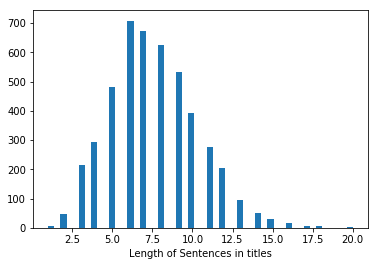

In [17]:
glove_idx2idx = dict((word2idx[w],embedding_idx) for  w, embedding_idx, _ in glove_match)
Y = [[word2idx[token] for token in title.split()] for title in titles]
print(len(Y))
plt.hist([len(p) for p in Y],bins=50);
plt.xlabel('Length of Sentences in titles')

Text(0.5, 0, 'Length of Sentences in abstracts')

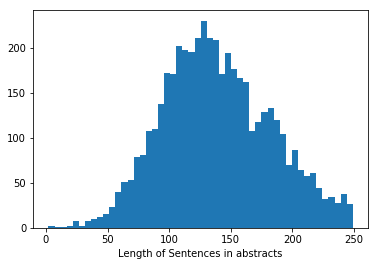

In [18]:
X = [[word2idx[token] for token in a.split()] for a in abstracts]
len(X)
plt.hist([len(p) for p in X],bins=50)
plt.xlabel('Length of Sentences in abstracts')

In [19]:
import pickle
pickle_path = '../data'
FN = 'embeddings.pkl'
with open(os.path.join(pickle_path,FN),'wb') as fp:
    pickle.dump((embedding, idx2word, word2idx, glove_idx2idx),fp,-1)

In [20]:
FN = 'data.pkl'
with open(os.path.join(pickle_path,FN),'wb') as fp:
    pickle.dump((X,Y),fp,-1)

In [21]:
print(X[0],Y[0])
print("Sentence : ",  [idx2word[p] for p in X[0]])
print("Summary : ", [idx2word[p] for p in Y[0]])

[18, 75, 34, 3, 2474, 1076, 2861, 10, 66, 1385, 13, 213, 6, 1162, 17650, 802, 2, 66, 2861, 21, 5217, 138, 160, 13, 152, 2628, 7, 2, 121, 3346, 773, 3, 17651, 18, 26, 3, 4250, 10, 2375, 23, 18, 2671, 3, 6032, 30, 1058, 4, 41, 2224, 3, 31, 668, 7, 2, 1349, 3346, 9805, 18, 1562, 6, 2101, 4504, 193, 5, 11, 6, 18, 3093, 2662, 1162, 174, 17, 7359] [4250, 3, 1076, 1671, 5, 67, 213]
Sentence :  ['an', 'efficient', 'method', 'of', 'self-organizing', 'associative', 'databases', 'is', 'proposed', 'together', 'with', 'applications', 'to', 'robot', 'eyesight', 'systems.', 'the', 'proposed', 'databases', 'can', 'associate', 'any', 'input', 'with', 'some', 'output.', 'in', 'the', 'first', 'half', 'part', 'of', 'discussion,', 'an', 'algorithm', 'of', 'self-organization', 'is', 'proposed.', 'from', 'an', 'aspect', 'of', 'hardware,', 'it', 'produces', 'a', 'new', 'style', 'of', 'neural', 'network.', 'in', 'the', 'latter', 'half', 'part,', 'an', 'applicability', 'to', 'handwritten', 'letter', 'recognitio

#### Training

In [22]:
K.clear_session()

In [23]:
p_W, p_U, p_dense, p_emb, weight_decay = 0, 0, 0, 0, 0
LR = 1e-4
batch_size = 2

def clip_to_batch(data, batch_size):
    data = data[0:len(data)-len(data)%batch_size]
    return data

# split data into train, validation, and test set
trainX, testX, trainY, testY = train_test_split(X, Y, test_size= 0.2 , random_state=seed)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size = 0.1 , random_state = seed)

trainX = clip_to_batch(trainX, batch_size)
trainY = clip_to_batch(trainY, batch_size)
valX = clip_to_batch(valX, batch_size)
valY = clip_to_batch(valY, batch_size)
testX = clip_to_batch(testX, batch_size)
testY = clip_to_batch(testY, batch_size)
print('Number of training samples: ', len(trainX))
print('Number of validation samples: ', len(valX))
print('Number of test samples: ', len(testX))

num_train_batches = len(trainX) // batch_size
num_val_samples = len(valX)
num_val_batches = len(valX) // batch_size
total_entries = (num_train_batches + num_val_batches)*batch_size
print('Number of training batches: ', num_train_batches)
print('Number of validation batches: ', num_val_batches)
print('Total entries: ', total_entries)

#maximum length for title 
# tMaxLen = 20
tMaxLen = 250
#maximum length for abstract
aMaxLen = 250
#total maximum length
maxlen = tMaxLen + aMaxLen
oov0 = vocab_size-nb_unknown_words

batch_norm=False

nUnique = embedding.shape[0]
hidden_units= embedding.shape[1]

learning_rate = 0.002
clip_norm = 1.0
val_samples = 300
regularizer = l2(weight_decay) if weight_decay else None

Number of training samples:  3354
Number of validation samples:  372
Number of test samples:  932
Number of training batches:  1677
Number of validation batches:  186
Total entries:  3726


In [24]:
#padding function for abstracts
def padAbstract(x, maxL = aMaxLen, dictionary = word2idx):
    n = len(x)
    if n > maxL:
        x = x[-maxL:]
        n = maxL
    return [dictionary['_']]*(maxL - n) + x + [dictionary['*']]

#build generator for model
def generator(trainX, trainY, batch_size = batch_size, 
              nb_batches = None, model = None, seed = seed):
    
    #UNDERSTAND THIS
    c = nb_batches if nb_batches else 0
    while True:
        titles = list()
        abstracts = list()
        if nb_batches and c >= nb_batches:
            c = 0
        new_seed = random.randint(0, sys.maxsize)
        random.seed(c+123456789+seed)
        
        for b in range(batch_size):
            a = random.randint(0,len(trainX)-1)
            
            #random shuffling of data
            abstract = trainX[a]
            s = random.randint(min(aMaxLen,len(abstract)), max(aMaxLen,len(abstract)))
            abstracts.append(abstract[:s])
            
            title = trainY[a]
            s = random.randint(min(tMaxLen,len(title)), max(tMaxLen,len(title)))
            titles.append(title[:s])

        # undo the seeding before we yield in order not to affect the caller
        c+= 1
        random.seed(new_seed)

        yield conv_seq_labels(abstracts, titles)

#pad sequence and convert title to labels
def conv_seq_labels(abstracts, titles, nflips = None, model = None, dictionary = word2idx):
    """abstract and titles are converted to padded input vectors. Titles are one-hot encoded to labels."""
    batch_size = len(titles)
    
    x = [padAbstract([a+t]) for a,t in zip(abstracts, titles)] 
    x = sequence.pad_sequences(x, maxlen = tMaxLen, value = dictionary['_'], 
                               padding = 'post', truncating = 'post')
        
    y = np.zeros((batch_size, tMaxLen, nUnique))
    for i, it in enumerate(titles):
        it = it + [dictionary['*']] + [dictionary['_']]*tMaxLen  # output does have a eos at end
        it = it[:tMaxLen]
        y[i,:,:] = np_utils.to_categorical(it, nUnique)
        
    #The 3 inputs are abstract, title starting with eos and a one-hot encoding of the title categorical variables.
    return [x[:,:aMaxLen],x[:,aMaxLen:]], y

In [25]:
def lpadd(x, maxlend=tMaxLen, eos=eos):
    assert maxlend >= 0
    if maxlend == 0:
        return [eos]
    n = len(x)
    if n > maxlend:
        x = x[-maxlend:]
        n = maxlend
    return [empty]*(maxlend-n) + x + [eos]

In [26]:
def vocab_fold(xs):
    xs = [x if x < oov0 else glove_idx2idx.get(x,x) for x in xs]
    # the more popular word is <0> and so on
    outside = sorted([x for x in xs if x >= oov0])
    # if there are more than nb_unknown_words oov words then put them all in nb_unknown_words-1
    outside = dict((x,vocab_size-1-min(i, nb_unknown_words-1)) for i, x in enumerate(outside))
    xs = [outside.get(x,x) for x in xs]
    return xs

def vocab_unfold(desc,xs):
    # assume desc is the unfolded version of the start of xs
    unfold = {}
    for i, unfold_idx in enumerate(desc):
        fold_idx = xs[i]
        if fold_idx >= vocab_size-nb_unknown_words:
            unfold[fold_idx] = unfold_idx
    return [unfold.get(x,x) for x in xs]

In [28]:
def gen(Xd, Xh, batch_size=batch_size, nb_batches=None, model=None, seed=seed):
    c = nb_batches if nb_batches else 0
    while True:
        xds = []
        xhs = []
        if nb_batches and c >= nb_batches:
            c = 0
        new_seed = random.randint(0, sys.maxsize)
        random.seed(c+123456789+seed)
        for b in range(batch_size):
            t = random.randint(0,len(Xd)-1)
            
            #random shuffling of data
            xd = Xd[t]
            s = random.randint(min(aMaxLen,len(xd)), max(aMaxLen,len(xd)))
            xds.append(xd[:s])
            
            xh = Xh[t]
            s = random.randint(min(tMaxLen,len(xh)), max(tMaxLen,len(xh)))
            xhs.append(xh[:s])

        # undo the seeding before we yield inorder not to affect the caller
        c+= 1
        random.seed(new_seed)

        yield conv_seq_labels(xds, xhs)

def conv_seq_labels(xds, xhs, nflips=None, model=None):
    """description and hedlines are converted to padded input vectors. headlines are one-hot to label"""
    batch_size = len(xhs)
    
    x = [vocab_fold(lpadd(xd)+xh) for xd,xh in zip(xds,xhs)]  # the input does not have 2nd eos
    x = sequence.pad_sequences(x, maxlen=maxlen, value= word2idx['_'], padding='post', truncating='post')
        
    y = np.zeros((batch_size, tMaxLen, vocab_size))
    for i, xh in enumerate(xhs):
        xh = vocab_fold(xh) + [eos] + [empty]*tMaxLen  # output does have a eos at end
        xh = xh[:tMaxLen]
        y[i,:,:] = np_utils.to_categorical(xh, vocab_size)
        
    #The 3 inputs are description, summary starting with eos and a one-hot encoding of the summary categoricals
    return [x[:,:aMaxLen],x[:,tMaxLen:]], y

In [29]:
#check generator
r = next(gen(trainX, trainY, batch_size=batch_size))
print(r[0][0].shape,r[0][1].shape,r[1].shape)
print("Description  : ", [idx2word[k] for k in r[0][0][0]])
print("Summary  : ", [idx2word[k] for k in r[0][0][1]])

(2, 250) (2, 250) (2, 250, 38659)
Description  :  ['<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', '<empty>', 'we', 'consider', 'the', 'problem', 'of', 'estimating', 'neural', 'spikes', 'from', 'extrac

In [30]:
#generator for training and validation
genTrain = gen(trainX, trainY, batch_size = batch_size)
genVal =  gen(valX, valY, nb_batches = len(valX)// batch_size, batch_size = batch_size)

In [31]:
#encoder
def getModel(genTrain, genVal, embeddMatrix=embedding, learning_rate=learning_rate, 
             clip_norm=clip_norm, encoder_shape = aMaxLen, decoder_shape = tMaxLen, 
             nUnique = vocab_size, embeddDim = embedding_dim, hidden_units = hidden_units):
    
    #ENCODER
    #input shape as the vector of sequence, with length padded to 250
    encoder_inputs = Input(shape = (encoder_shape, ), name = 'encoder_input')
    
    encoder_embedding = Embedding(nUnique, embeddDim, 
                                  input_length = encoder_shape, 
                                  weights = [embeddMatrix],
                                  mask_zero = True,
                                  name = 'encoder_embedd')(encoder_inputs)
    
    encoder_lstm = Bidirectional(LSTM(hidden_units, dropout = 0.2, recurrent_dropout=0.2, return_state=True))
    
    encoder_outputs, f_h, f_c, b_h, b_c = encoder_lstm(encoder_embedding)
    
    state_hfinal=Add()([f_h, b_h])
    state_cfinal=Add()([f_c, b_c])
    
    encoder_states = [state_hfinal,state_cfinal]
        
    #DECODER
    decoder_inputs = Input(shape = (decoder_shape, ), name = 'decoder_input')
    
    decoder_embedding = Embedding(nUnique, embeddDim, 
                                  input_length = decoder_shape, 
                                  weights = [embeddMatrix],
                                  mask_zero = True,
                                  name = 'decoder_embedd')
    
    decoder_lstm = LSTM(hidden_units, return_sequences = True, return_state=True)
    
    decoder_outputs, s_h, s_c = decoder_lstm(decoder_embedding(decoder_inputs), initial_state = encoder_states)    
    decoder_dense = Dense(decoder_shape, activation='linear')
    decoder_time_distributed = TimeDistributed(Dense(nUnique,
                                                     name = 'decoder_timedistributed'))
    decoder_activation = Activation('softmax', name = 'decoder_activation')
    decoder_outputs = decoder_activation(decoder_time_distributed(decoder_outputs))
    
    #MODEL
    model = Model(inputs = [encoder_inputs,decoder_inputs], outputs = decoder_outputs) 
    rmsprop = RMSprop(lr = learning_rate, clipnorm = clip_norm)
    model.compile(loss = 'categorical_crossentropy',optimizer = rmsprop)
    
    #ENCODER MODEL
    encoder_model = Model(encoder_inputs,encoder_states)
    
    #DECODER MODEL
    decoder_state_inputs_h = Input(shape=(hidden_units,))
    decoder_state_inputs_c = Input(shape=(hidden_units,)) 
    decoder_state_inputs = [decoder_state_inputs_h, decoder_state_inputs_c]
    decoder_outputs, decoder_state_h, decoder_state_c = decoder_lstm(decoder_embedding(decoder_inputs),
                                                                     initial_state = decoder_state_inputs)
    decoder_states = [decoder_state_h, decoder_state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = Model([decoder_inputs] + decoder_state_inputs,
                          [decoder_outputs] + decoder_states)
    
    return model, encoder_model, decoder_model

In [32]:
def saveModels(models,names):
    path = '../models'
    for i in range(len(names)):
        models[i].save(os.path.join(path,names[i]))

In [33]:
K.clear_session()
model, encoder, decoder = getModel(genTrain,genVal)
# saveModels([model,encoder,decoder],['att_model','att_encoder','att_decoder'])

In [34]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 250)          0                                            
__________________________________________________________________________________________________
encoder_embedd (Embedding)      (None, 250, 100)     3865900     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, 250)          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 200), (None, 160800      encoder_embedd[0][0]             
__________________________________________________________________________________________________
decoder_em

In [36]:
# model.fit_generator(genTrain, steps_per_epoch = 100, epochs=5, validation_data = genVal,validation_steps = 20)
# save_weights('../weights')

In [35]:
def load_weights(folder):
    model.load_weights(folder + '/model.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')
    
def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    model.save_weights(folder + '/model.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')

In [37]:
load_weights('../weights')

In [38]:
def getPredictions(model, seq, maxLen, num_iteration, idx2word):
    '''
    Prediction for a given sequence. 
    
    Parameters:
    ===========
    1)model: rnn model
    2)seq: a single abstract, should be a vector of length 250
    3)maxLen: maximum length of predicted title
    4)idx2word: dictionary for index to word
    '''
    
    #cache list of prediction
    prediction = list()
    #initiate title to be a vector of zeros
    init = np.zeros(maxLen)
    
    #for maximum prediction length
    for i in range(num_iteration):
        #get prediction probabilities for all unique words
        predRNN = model.predict([np.reshape(seq, (1, 250)), init.reshape(1, 250)])
        #greedy mode prediction
        #update next title vector to be the predicted vector
        init = np.argmax(predRNN, axis = 2)
        #get probabilities of all unique words
        pVec = predRNN[0, 0, :]
        #get the word with maximum predicted probability as the predicted words
        idx = np.argmax(pVec)
        #index to word
        word = idx2word[idx]
        #if eos tag is predicted
        #break out of loop
        if idx == 1:
            break
        prediction.append(word)
    return prediction

In [39]:
#check prediction 
check = testX.copy()
check = sequence.pad_sequences(check, 250, value = word2idx['_'], padding = 'pre')

ind=0
print([idx2word[m] for m in testY[ind]])
print([idx2word[m] for m in check[ind]])
check_pred = getPredictions(model, check[ind], 250, 20, idx2word)
print(check_pred)

['universal', 'consistency', 'of', 'multi-class', 'support', 'vector', 'classification']
['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', 'steinwart', 'was', 'the', '?rst', 'to', 'prove', 'univ

#### Beam Search

In [40]:
def keras_rnn_predict(samples, empty=empty, model=model, maxlen=maxlen):
    """for every sample, calculate probability for every possible label
    you need to supply your RNN model and maxlen - the length of sequences it can handle
    """
    sample_lengths = map(len, samples)
    assert all(l > aMaxLen for l in sample_lengths)
    assert all(l[aMaxLen] == eos for l in samples)
    # pad from right (post) so the first maxlend will be description followed by headline
    data = sequence.pad_sequences(samples, maxlen=maxlen, value=empty, padding='post', truncating='post')
    data1 = data[0][0:250]
    data2 = data[0][250:]
    probs = model.predict([np.reshape(data1, (1, 250)), data2.reshape(1, 250)])[0][0]
    softmax = [output2probs(prob[sample_length-maxlend-1]) for prob, sample_length in zip(probs, sample_lengths)]
    softmax = probs.reshape(1,-1)
    return np.array(softmax)

In [41]:
def beamsearch(predict, start=[empty]*aMaxLen + [eos], avoid=None, avoid_score=1,
               k=1, maxsample=maxlen, use_unk=True, oov=vocab_size-1, empty=empty, eos=eos, temperature=1.0):
    """return k samples (beams) and their NLL scores, each sample is a sequence of labels,
    all samples starts with an `empty` label and end with `eos` or truncated to length of `maxsample`.
    You need to supply `predict` which returns the label probability of each sample.
    `use_unk` allow usage of `oov` (out-of-vocabulary) label in samples
    """
    def sample(energy, n, temperature=temperature):
        """sample at most n different elements according to their energy"""
        n = min(n,len(energy))
        prb = np.exp(-np.array(energy) / temperature )
        res = []
        for i in range(n):
            z = np.sum(prb)
            r = np.argmax(np.random.multinomial(1, prb/z, 1))
            res.append(r)
            prb[r] = 0. # make sure we select each element only once
        return res

    dead_samples = []
    dead_scores = []
    live_samples = [list(start)]
    live_scores = [0]
    counter = 1
    
    while live_samples:
        # for every possible live sample calc prob for every possible label 
        probs = predict(live_samples, empty=empty)
        assert vocab_size == probs.shape[1]

        # total score for every sample is sum of -log of word prb
        cand_scores = np.array(live_scores)[:,None] - np.log(probs)
        cand_scores[:,empty] = 1e20
        if not use_unk and oov is not None:
            cand_scores[:,oov] = 1e20
        if avoid:
            for a in avoid:
                for i, s in enumerate(live_samples):
                    n = len(s) - len(start)
                    if n < len(a):
                        # at this point live_sample is before the new word,
                        # which should be avoided, is added
                        cand_scores[i,a[n]] += avoid_score
        live_scores = list(cand_scores.flatten())

        # find the best (lowest) scores we have from all possible dead samples and
        # all live samples and all possible new words added
        scores = dead_scores + live_scores
        ranks = sample(scores, k)
        n = len(dead_scores)
        dead_scores = [dead_scores[r] for r in ranks if r < n]
        dead_samples = [dead_samples[r] for r in ranks if r < n]
        
        live_scores = [live_scores[r-n] for r in ranks if r >= n]
        live_samples = [live_samples[(r-n)//vocab_size]+[(r-n)%vocab_size] for r in ranks if r >= n]

        # live samples that should be dead are...
        # even if len(live_samples) == maxsample we dont want it dead because we want one
        # last prediction out of it to reach a headline of maxlenh
        def is_zombie(s):
            return s[-1] == eos or len(s) > maxsample
        
        # add zombies to the dead
        dead_scores += [c for s, c in zip(live_samples, live_scores) if is_zombie(s)]
        dead_samples += [s for s in live_samples if is_zombie(s)]
        
        # remove zombies from the living 
        live_scores = [c for s, c in zip(live_samples, live_scores) if not is_zombie(s)]
        live_samples = [s for s in live_samples if not is_zombie(s)]
        counter += 1
    
    print(counter)
    return dead_samples, dead_scores

In [44]:
def gensamples(X=None,  avoid=None, avoid_score=1, skips=2, k=10, batch_size=batch_size, 
               short=True, temperature=1., use_unk=True):
    if X is None or isinstance(X,int):
        if X is None:
            i = random.randint(0,len(testX)-1)
        else:
            i = X
        print('TITLE %d:'%i,' '.join(idx2word[w] for w in testY[i]))
        print('ABSTRACT:',' '.join(idx2word[w] for w in testX[i]))
        x = testX[i]
    else:
        x = [word2idx[w.rstrip('^')] for w in X.split()]
        
    if avoid:
        # avoid is a list of avoids. Each avoid is a string or list of word indicies
        if isinstance(avoid,str) or isinstance(avoid[0], int):
            avoid = [avoid]
        avoid = [a.split() if isinstance(a,str) else a for a in avoid]
        avoid = [vocab_fold([w if isinstance(w,int) else word2idx[w] for w in a])
                 for a in avoid]

    print('TITLES:')
    samples = []
    skips = range(min(aMaxLen,len(x)), max(aMaxLen,len(x)), abs(aMaxLen - len(x)) // skips + 1)
    print(skips)
    for s in skips:
        start = lpadd(x[:s])
        fold_start = vocab_fold(start)
        sample, score = beamsearch(predict=keras_rnn_predict, start=fold_start, avoid=avoid, 
                                   avoid_score=avoid_score,k=k, temperature=temperature, use_unk=use_unk)
        assert all(s[aMaxLen] == eos for s in sample)
        samples += [(s,start,scr) for s,scr in zip(sample,score)]
    
    samples.sort(key=lambda x: x[-1])
    return samples

In [52]:
samples = gensamples()
codes = []
short=True
for sample, start, score in samples:
    code = ''
    words = []
    sample = vocab_unfold(start, sample)[len(start):]
    for w in sample:
        if w == eos:
            break
        words.append(idx2word[w])
        code += chr(w//(256*256)) + chr((w//256)%256) + chr(w%256)
    if short:
        distance = min([100] + [-Levenshtein.jaro(code,c) for c in codes])
        if distance > -0.6:
            print(score, ' '.join(words))
    else:
            print(score, ' '.join(words))
    codes.append(code)

TITLE 688: multi-level active prediction of useful image annotations for recognition
ABSTRACT: we introduce a framework for actively learning visual categories from a mixture of weakly and strongly labeled image examples. we propose to allow the category-learner to strategically choose what annotations it receives---based on both the expected reduction in uncertainty as well as the relative costs of obtaining each annotation. we construct a multiple-instance discriminative classifier based on the initial training data. then all remaining unlabeled and weakly labeled examples are surveyed to actively determine which annotation ought to be requested next. after each request, the current classifier is incrementally updated. unlike previous work, our approach accounts for the fact that the optimal use of manual annotation may call for a combination of labels at multiple levels of granularity (e.g., a full segmentation on some images and a present/absent flag on others). as a result, it is 

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


251
263.9286901950836 a bayesian learning the bayesian efficient learning a a order bayesian learning map efficient networks the and with nonparametric the a learning stochastic neural a a learning adaptive a learning learning in learning learning the a adaptive matrix a in with learning learning with inference a bayesian a learning with a a for for on learning a learning bayesian learning learning learning the learning a


---